# Семинар по деревьям

Берем данные boston

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import re
from sklearn.cross_validation import train_test_split

In [2]:
boston = load_boston()

In [3]:
boston.keys()

['data', 'feature_names', 'DESCR', 'target']

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(boston["data"], boston["target"])

In [5]:
data_train = pd.DataFrame(X_tr, columns=boston["feature_names"])
data_test = pd.DataFrame(X_te, columns=boston["feature_names"])

In [6]:
data_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.03306,0.0,5.19,0.0,0.515,6.059,37.3,4.8122,5.0,224.0,20.2,396.14,8.51
1,0.20608,22.0,5.86,0.0,0.431,5.593,76.5,7.9549,7.0,330.0,19.1,372.49,12.50
2,3.16360,0.0,18.10,0.0,0.655,5.759,48.2,3.0665,24.0,666.0,20.2,334.40,14.13
3,0.08826,0.0,10.81,0.0,0.413,6.417,6.6,5.2873,4.0,305.0,19.2,383.73,6.72
4,0.03659,25.0,4.86,0.0,0.426,6.302,32.2,5.4007,4.0,281.0,19.0,396.90,6.72


In [7]:
data_train.shape

(379, 13)

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

Далее мы будем реализовывать первый шаг в построении решающего дерева - выбор признака и порога для разделения в корне дерева. Мы будем писать максимально понятный, но не оптимальный, код, т. е. в sklearn все реализовано более эффективно.

In [9]:
# чтобы было удобно сортировать объекты вместе с целевым вектором, допишем его в датафрейм
data_train['target'] = y_tr

In [10]:
# чтобы было удобно перебирать порог на первый признак, сортируем датафрейм по нему
data_train.sort_values('CRIM', inplace=True)

In [11]:
data_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
151,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
304,0.01096,55.0,2.25,0.0,0.389,6.453,31.9,7.3073,1.0,300.0,15.3,394.72,8.23,22.0
328,0.01301,35.0,1.52,0.0,0.442,7.241,49.3,7.0379,1.0,284.0,15.5,394.74,5.49,32.7
89,0.01311,90.0,1.22,0.0,0.403,7.249,21.9,8.6966,5.0,226.0,17.9,395.93,4.81,35.4
133,0.01360,75.0,4.00,0.0,0.410,5.888,47.6,7.3197,3.0,469.0,21.1,396.90,14.80,18.9


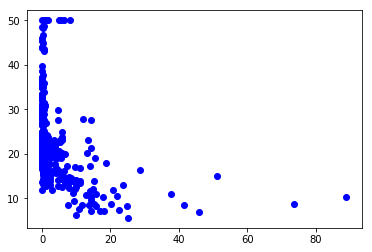

In [19]:
plt.plot(data_train['CRIM'], data_train['target'], 'bo')

In [14]:
# считаем качество - дисперсию ответов в левом и
# правом поддереве с весами, как в лекции
quals = []
n = data_train.shape[0]
for i in range(n):
    quality = data_train['target'][:i].std()**2 * (i+1) / \
        n + data_train['target'][i:].std()**2 * (1-(i+1)/n)
    quals.append(quality)

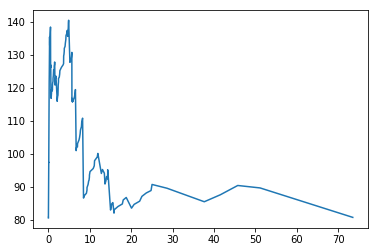

In [15]:
# рисуем график порог - качество разделения
plt.plot(data_train['CRIM'], quals)

Чем меньше, тем лучше, поэтому оптимум остигается где-то в CRIM = 7.

Теперь сделаем это для каждого признака (copypaste - это очень плохо, но для демонстрации хорошо).

Обратите внимание: чтобы было удобно сравнивать значение критерия для разных признаков, мы все рисуем на одном графике. Но шкала (множество значений) у каждого признака своя. Так что мы будем откладывать по оси x просто числа от 0 до длины выборки, и величину оптимального порога по графику будет определить нельзя. По графику мы сможем определить только оптимальный признак для разделения.

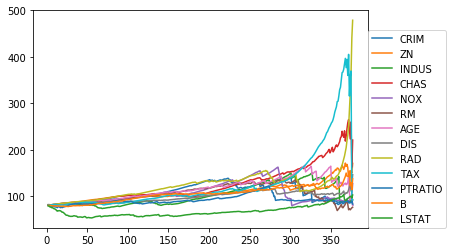

In [20]:
for feat in data_train.columns[:-1]:
    # code for one feature here
    quals = []
    data_train.sort_values(feat, inplace=True)
    for i in range(data_train.shape[0]):
        quality = data_train["target"][:i].std()**2 * i/data_train.shape[0] + data_train["target"][i:].std()**2 * (1-i/data_train.shape[0])
        quals.append(quality)
    plt.plot(quals, label=feat)
plt.legend(loc=(1, 0))

Кажется, выиграл LSTAT. Нарисуем для него график отдельно (уже с его осью): 

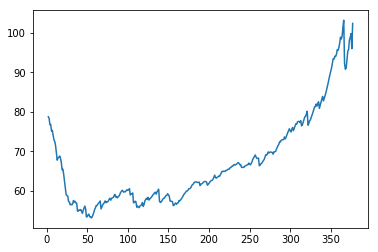

In [21]:
feat = 'LSTAT'
quals = []
data_train.sort_values(feat, inplace=True)
for i in range(data_train.shape[0]):
    quality = data_train["target"][:i].std()**2 * i/data_train.shape[0] + data_train["target"][i:].std()**2 * (1-i/data_train.shape[0])
    quals.append(quality)
plt.plot(quals, label=feat)

Величина порога:

In [22]:
thresh = data_train[feat][np.argmin(quals)]
print(thresh)

8.51


Нарисуем выборку в осях LSTAT - target и изобразим порог, по которому мы разделили

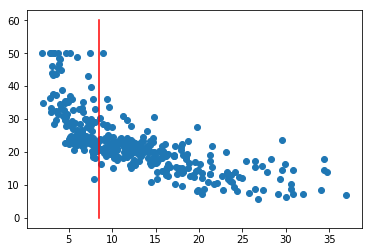

In [23]:
plt.scatter(data_train["LSTAT"], data_train["target"])
plt.plot([thresh, thresh], [0, 60], color="red")

Видно, что точки справа от красной линии лежат почти все выше 30, а слева - ниже, т. е. этот признак действительно очень хорошо разделяет выборку.

## Критерий останова построения дерева

Очевидно, для любой обучающей выборки можно построить решающее дерево, которое имеет нулевую ошибку на данной выборке. Однако в этом случае имеет место **переобучение**.

В связи с этим встаёт вопрос: в каком случае вершину следует объявить листовой?

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевой переменной — расстояние от объекта до точки (0, 0).

In [24]:
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline

In [25]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

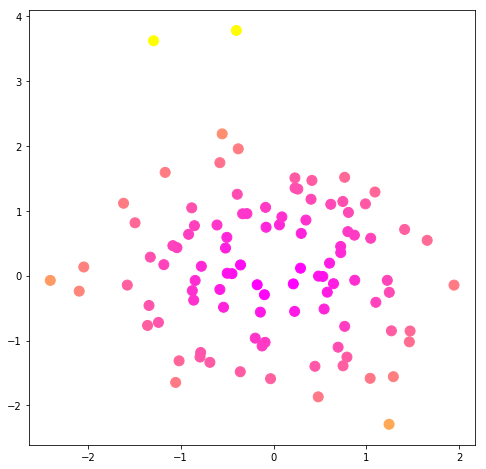

In [26]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

#### 1. Все объекты в вершине относятся к одному к классу.

    Простое условие, но приводит к переобучению.

In [27]:
from sklearn.tree import DecisionTreeRegressor

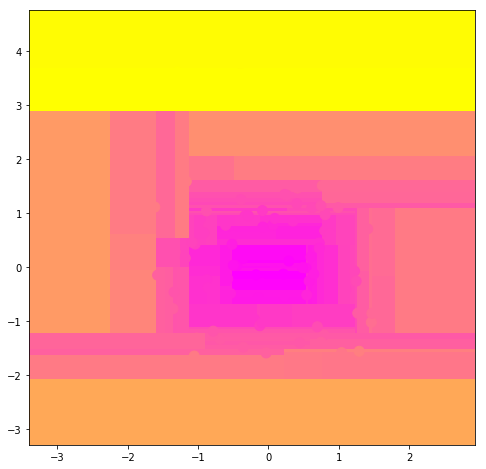

In [28]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

#### 2. При дальнейшем разбиении выборки глубина дерева превысит допустимую максимальную глубину.
#### 3. При дальнейшем разбиении количество объектов в листьях станет меньше допустимого порога.

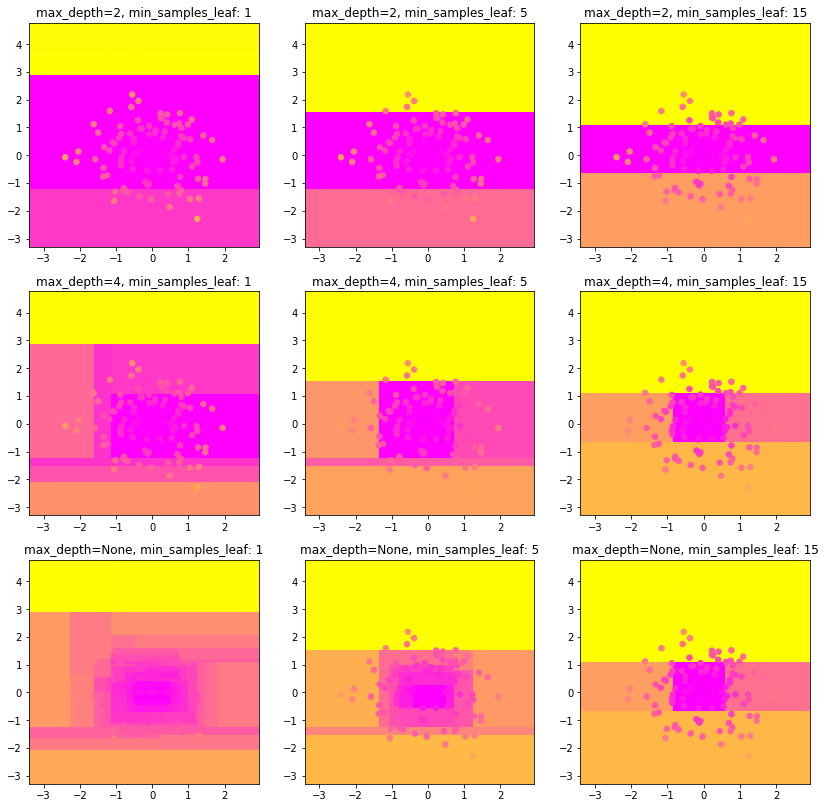

In [29]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([1, 5, 15]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

Можно увидеть, что увеличение глубины дерева и уменьшение количества объектов в листьях способствует гибкости модели и, как следствие, переобучению. 

#### 4. Стрижка деревьев (pruning)
Все предыдущие критерии останова были направлены против построения переобученного дерева. При использовании прунинга сначала строится максимально переобученное дерево, после чего оно усовершенствуется путем удаления некоторых листовых вершин. Данный способ работает лучше, чем рассмотренные ранее, однако является более трудоёмким.

# Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.


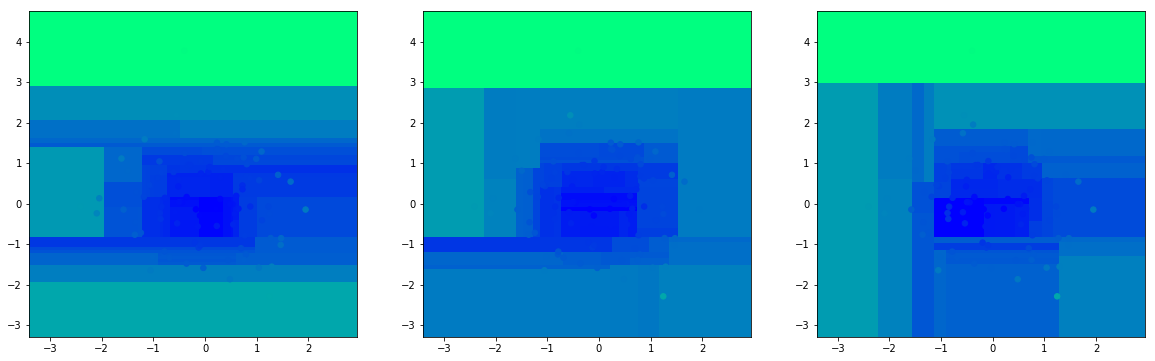

In [31]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter')

# Решающие леса

Чтобы уменьшить влияние рассмотренных недостатков решающих деревьев, используют **случайные леса (random forest)**. Одно дерево может ошибаться, поэтому давайте построим много деревьев и "усредним" их ответы.

Если строить все эти леса по одной и той же обучающей выборке, они будут одинаковые, поэтому для каждого решающего дерева, которое мы строим:
* вместо исходной обучающей выборки $X^l$ используется бутстрап (т.е. выборка $l$ объектов **с возвращениями**);
* в каждой внутренней вершине выбор условия осуществляется не среди всех признаков, а среди $q$ случайно выбранных.

Такая рандомизация обеспечит нам различность деревьев. После того, как таким образом были получены алгоритмы $b_1(x), ... b_N(x)$ можно построить итоговый алгоритм как:
* **выбор большинства** в случае классификации: $a(x) = \arg \max_{y in \mathbb{Y}} \sum_{n=1}^N [b_n(x) = y]$
* **среднее** в случае регрессии: $a(x) = \frac{1}{N} \sum_{n = 1}^N b_n(x)$

In [32]:
from sklearn.ensemble import RandomForestRegressor

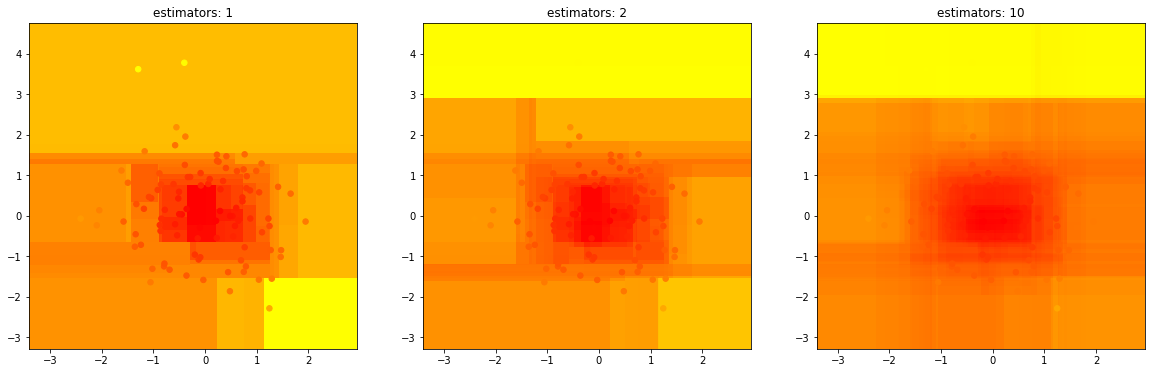

In [33]:
plt.figure(figsize=(20, 6))
for i, n in enumerate([1, 2, 10]):
    clf = RandomForestRegressor(n_estimators=n, random_state=42)
    clf.fit(data_x, data_y)
    xx, yy = get_grid(data_x)
    
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.subplot2grid((1, 3), (0, i))
    
    plt.pcolormesh(xx, yy, predicted, cmap='autumn')
    
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='autumn')
    plt.title('estimators: %i' % n)

plt.show()